# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
#     env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    rewards.append(reward)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        rewards = []
        env.reset()

state, action, reward, done, info
[ 0.14086784  1.00932526 -0.23855598 -1.65737781] 0 1.0 True {}
state, action, reward, done, info
[-0.13476196 -0.00096462  0.21252394  0.57971826] 0 1.0 True {}
state, action, reward, done, info
[ 0.11912759  1.16149618 -0.23402477 -2.05544141] 1 1.0 True {}
state, action, reward, done, info
[-0.12836071  0.39694507 -0.22674956 -1.78709871] 1 1.0 True {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name=None)
    actions = tf.placeholder(tf.int32, [None], name=None)

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name=None)
    return states, actions, targetQs

In [6]:
def generator(states, hidden_size, action_size):
    with tf.variable_scope('generator'):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(0.1 * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(0.1 * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(nl2, action_size)
        # out = tf.tanh(logits)

        return logits

In [7]:
def model_loss(states, hidden_size, actions, action_size, targetQs):
    # Output layer
    outputs = generator(states=states, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    one_hot_actions = tf.one_hot(actions, action_size)

    # Train with loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(outputs, one_hot_actions), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs - Qs))
    
    return outputs, Qs, loss

In [8]:
class QNetwork:
    def __init__(self, state_size, action_size, hidden_size):
        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.outputs, self.Qs, self.loss = model_loss(action_size=action_size, actions=self.actions, 
                                                      states=self.states, hidden_size=hidden_size, 
                                                      targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer().minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [9]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size

In [11]:
tf.reset_default_graph()
# mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)
mainQN = QNetwork(action_size=action_size, hidden_size=hidden_size, state_size=state_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [12]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [13]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {mainQN.states: state.reshape((1, *state.shape))}
                targetQ = sess.run(mainQN.outputs, feed_dict)
                action = np.argmax(targetQ)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            next_targetQs = sess.run(mainQN.outputs, feed_dict={mainQN.states: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_targetQs[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = rewards + (gamma * np.max(next_targetQs, axis=1))

            # Updating the model
            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.states: states,
                                           mainQN.targetQs: targetQs,
                                           mainQN.actions: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/cartpole__.ckpt")

Episode: 0 Total reward: 8.0 Training loss: 1.0874 Explore P: 0.9992
Episode: 1 Total reward: 20.0 Training loss: 1.2377 Explore P: 0.9972
Episode: 2 Total reward: 30.0 Training loss: 1.5562 Explore P: 0.9943
Episode: 3 Total reward: 16.0 Training loss: 1.9994 Explore P: 0.9927
Episode: 4 Total reward: 16.0 Training loss: 3.6200 Explore P: 0.9911
Episode: 5 Total reward: 13.0 Training loss: 5.1919 Explore P: 0.9899
Episode: 6 Total reward: 17.0 Training loss: 6.8195 Explore P: 0.9882
Episode: 7 Total reward: 32.0 Training loss: 8.3824 Explore P: 0.9851
Episode: 8 Total reward: 31.0 Training loss: 15.6182 Explore P: 0.9820
Episode: 9 Total reward: 12.0 Training loss: 4.3333 Explore P: 0.9809
Episode: 10 Total reward: 35.0 Training loss: 26.4544 Explore P: 0.9775
Episode: 11 Total reward: 42.0 Training loss: 1.8352 Explore P: 0.9734
Episode: 12 Total reward: 19.0 Training loss: 19.7944 Explore P: 0.9716
Episode: 13 Total reward: 43.0 Training loss: 25.9861 Explore P: 0.9675
Episode: 14 T

Episode: 116 Total reward: 62.0 Training loss: 18.9980 Explore P: 0.7285
Episode: 117 Total reward: 53.0 Training loss: 19.2871 Explore P: 0.7247
Episode: 118 Total reward: 40.0 Training loss: 107.9562 Explore P: 0.7218
Episode: 119 Total reward: 17.0 Training loss: 401.7910 Explore P: 0.7206
Episode: 120 Total reward: 95.0 Training loss: 1233.9978 Explore P: 0.7139
Episode: 121 Total reward: 29.0 Training loss: 12.8478 Explore P: 0.7118
Episode: 122 Total reward: 93.0 Training loss: 12.9920 Explore P: 0.7053
Episode: 123 Total reward: 77.0 Training loss: 14.0781 Explore P: 0.7000
Episode: 124 Total reward: 67.0 Training loss: 36.0965 Explore P: 0.6954
Episode: 125 Total reward: 42.0 Training loss: 42.4011 Explore P: 0.6925
Episode: 126 Total reward: 21.0 Training loss: 464.9306 Explore P: 0.6911
Episode: 127 Total reward: 42.0 Training loss: 459.0634 Explore P: 0.6882
Episode: 128 Total reward: 13.0 Training loss: 15.8319 Explore P: 0.6874
Episode: 129 Total reward: 79.0 Training loss

Episode: 226 Total reward: 199.0 Training loss: 21.7644 Explore P: 0.1665
Episode: 227 Total reward: 199.0 Training loss: 16.5810 Explore P: 0.1634
Episode: 228 Total reward: 199.0 Training loss: 4.3946 Explore P: 0.1604
Episode: 229 Total reward: 189.0 Training loss: 5.1372 Explore P: 0.1575
Episode: 230 Total reward: 199.0 Training loss: 1187.7449 Explore P: 0.1546
Episode: 231 Total reward: 199.0 Training loss: 3.8266 Explore P: 0.1518
Episode: 232 Total reward: 195.0 Training loss: 6.3720 Explore P: 0.1490
Episode: 233 Total reward: 199.0 Training loss: 6.9381 Explore P: 0.1463
Episode: 234 Total reward: 199.0 Training loss: 2.2717 Explore P: 0.1436
Episode: 235 Total reward: 199.0 Training loss: 6.8558 Explore P: 0.1410
Episode: 236 Total reward: 199.0 Training loss: 198.5465 Explore P: 0.1384
Episode: 237 Total reward: 174.0 Training loss: 38.5138 Explore P: 0.1362
Episode: 238 Total reward: 199.0 Training loss: 5.9450 Explore P: 0.1337
Episode: 239 Total reward: 199.0 Training l

Episode: 337 Total reward: 199.0 Training loss: 16.0482 Explore P: 0.0378
Episode: 338 Total reward: 199.0 Training loss: 18.7543 Explore P: 0.0372
Episode: 339 Total reward: 199.0 Training loss: 10.6395 Explore P: 0.0367
Episode: 340 Total reward: 199.0 Training loss: 16.1346 Explore P: 0.0361
Episode: 341 Total reward: 199.0 Training loss: 8.6641 Explore P: 0.0356
Episode: 342 Total reward: 199.0 Training loss: 32.5142 Explore P: 0.0351
Episode: 343 Total reward: 126.0 Training loss: 22.9332 Explore P: 0.0348
Episode: 344 Total reward: 70.0 Training loss: 796.8936 Explore P: 0.0346
Episode: 345 Total reward: 10.0 Training loss: 2257.3728 Explore P: 0.0346
Episode: 346 Total reward: 8.0 Training loss: 1509.8108 Explore P: 0.0346
Episode: 347 Total reward: 10.0 Training loss: 254.0021 Explore P: 0.0346
Episode: 348 Total reward: 8.0 Training loss: 291.1003 Explore P: 0.0346
Episode: 349 Total reward: 9.0 Training loss: 463.1143 Explore P: 0.0345
Episode: 350 Total reward: 11.0 Training

Episode: 448 Total reward: 199.0 Training loss: 217.4556 Explore P: 0.0192
Episode: 449 Total reward: 171.0 Training loss: 47.4792 Explore P: 0.0191
Episode: 450 Total reward: 144.0 Training loss: 102.4071 Explore P: 0.0190
Episode: 451 Total reward: 147.0 Training loss: 128.9658 Explore P: 0.0188
Episode: 452 Total reward: 148.0 Training loss: 72.4059 Explore P: 0.0187
Episode: 453 Total reward: 199.0 Training loss: 41.5058 Explore P: 0.0185
Episode: 454 Total reward: 179.0 Training loss: 31.3552 Explore P: 0.0184
Episode: 455 Total reward: 199.0 Training loss: 60.6823 Explore P: 0.0182
Episode: 456 Total reward: 130.0 Training loss: 58.0127 Explore P: 0.0181
Episode: 457 Total reward: 190.0 Training loss: 30.7768 Explore P: 0.0180
Episode: 458 Total reward: 165.0 Training loss: 46.6829 Explore P: 0.0178
Episode: 459 Total reward: 199.0 Training loss: 38.6787 Explore P: 0.0177
Episode: 460 Total reward: 185.0 Training loss: 35.7708 Explore P: 0.0175
Episode: 461 Total reward: 199.0 Tr

Episode: 559 Total reward: 199.0 Training loss: 55.5114 Explore P: 0.0122
Episode: 560 Total reward: 199.0 Training loss: 42.1748 Explore P: 0.0122
Episode: 561 Total reward: 199.0 Training loss: 85.1704 Explore P: 0.0121
Episode: 562 Total reward: 199.0 Training loss: 49.4320 Explore P: 0.0121
Episode: 563 Total reward: 199.0 Training loss: 208.6500 Explore P: 0.0121
Episode: 564 Total reward: 199.0 Training loss: 326.2732 Explore P: 0.0120
Episode: 565 Total reward: 199.0 Training loss: 29.2298 Explore P: 0.0120
Episode: 566 Total reward: 199.0 Training loss: 54.2301 Explore P: 0.0119
Episode: 567 Total reward: 199.0 Training loss: 19.0428 Explore P: 0.0119
Episode: 568 Total reward: 199.0 Training loss: 32.4473 Explore P: 0.0119
Episode: 569 Total reward: 191.0 Training loss: 871.9955 Explore P: 0.0118
Episode: 570 Total reward: 175.0 Training loss: 34.0565 Explore P: 0.0118
Episode: 571 Total reward: 199.0 Training loss: 794.6421 Explore P: 0.0118
Episode: 572 Total reward: 199.0 T

Episode: 671 Total reward: 12.0 Training loss: 3208142.2500 Explore P: 0.0109
Episode: 672 Total reward: 10.0 Training loss: 28530.7383 Explore P: 0.0109
Episode: 673 Total reward: 9.0 Training loss: 37291.1016 Explore P: 0.0109
Episode: 674 Total reward: 9.0 Training loss: 16044.3965 Explore P: 0.0109
Episode: 675 Total reward: 13.0 Training loss: 6548566.0000 Explore P: 0.0109
Episode: 676 Total reward: 13.0 Training loss: 35414.8203 Explore P: 0.0109
Episode: 677 Total reward: 9.0 Training loss: 5622323.0000 Explore P: 0.0109
Episode: 678 Total reward: 9.0 Training loss: 10467.1211 Explore P: 0.0109
Episode: 679 Total reward: 9.0 Training loss: 20730.6191 Explore P: 0.0109
Episode: 680 Total reward: 8.0 Training loss: 15675573.0000 Explore P: 0.0109
Episode: 681 Total reward: 7.0 Training loss: 8634.8965 Explore P: 0.0109
Episode: 682 Total reward: 12.0 Training loss: 7852.4502 Explore P: 0.0109
Episode: 683 Total reward: 7.0 Training loss: 9148.1309 Explore P: 0.0109
Episode: 684 T

Episode: 779 Total reward: 199.0 Training loss: 1788.7805 Explore P: 0.0105
Episode: 780 Total reward: 199.0 Training loss: 1844.8398 Explore P: 0.0105
Episode: 781 Total reward: 122.0 Training loss: 3006.6460 Explore P: 0.0105
Episode: 782 Total reward: 165.0 Training loss: 5070.6055 Explore P: 0.0105
Episode: 783 Total reward: 199.0 Training loss: 2608.6218 Explore P: 0.0105
Episode: 784 Total reward: 199.0 Training loss: 4068.3625 Explore P: 0.0105
Episode: 785 Total reward: 199.0 Training loss: 12682.2119 Explore P: 0.0105
Episode: 786 Total reward: 196.0 Training loss: 35362.0195 Explore P: 0.0105
Episode: 787 Total reward: 168.0 Training loss: 627.6108 Explore P: 0.0105
Episode: 788 Total reward: 199.0 Training loss: 1566.4249 Explore P: 0.0105
Episode: 789 Total reward: 199.0 Training loss: 390.5923 Explore P: 0.0104
Episode: 790 Total reward: 199.0 Training loss: 133.5044 Explore P: 0.0104
Episode: 791 Total reward: 199.0 Training loss: 321.1829 Explore P: 0.0104
Episode: 792 T

Episode: 889 Total reward: 65.0 Training loss: 225272.6719 Explore P: 0.0101
Episode: 890 Total reward: 71.0 Training loss: 7737.6514 Explore P: 0.0101
Episode: 891 Total reward: 113.0 Training loss: 3617.8745 Explore P: 0.0101
Episode: 892 Total reward: 199.0 Training loss: 2273.4065 Explore P: 0.0101
Episode: 893 Total reward: 199.0 Training loss: 197.5645 Explore P: 0.0101
Episode: 894 Total reward: 199.0 Training loss: 18143.1523 Explore P: 0.0101
Episode: 895 Total reward: 199.0 Training loss: 424.9968 Explore P: 0.0101
Episode: 896 Total reward: 199.0 Training loss: 429.7397 Explore P: 0.0101
Episode: 897 Total reward: 199.0 Training loss: 865.6483 Explore P: 0.0101
Episode: 898 Total reward: 199.0 Training loss: 566.9349 Explore P: 0.0101
Episode: 899 Total reward: 199.0 Training loss: 303.8695 Explore P: 0.0101
Episode: 900 Total reward: 199.0 Training loss: 304.1122 Explore P: 0.0101
Episode: 901 Total reward: 199.0 Training loss: 174.3018 Explore P: 0.0101
Episode: 902 Total 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

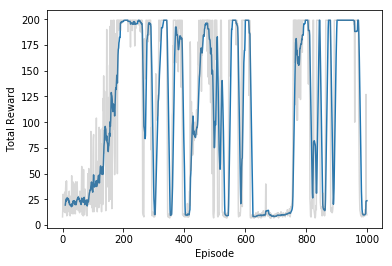

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.